# Access Sentinel 2 Data from AWS

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/opendatacube/odc-stac/develop?labpath=notebooks%2Fstac-load-e84-aws.ipynb)

https://registry.opendata.aws/sentinel-2-l2a-cogs/

In [1]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

## Start Dask Client

This step is optional, but it does improve load speed significantly. You
don't have to use Dask, as you can load data directly into memory of the
notebook.

In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

<Client: 'tcp://127.0.0.1:38803' processes=4 threads=4, memory=15.62 GiB>

## Find STAC Items to Load

In [3]:
km2deg = 1.0 / 111
x, y = (113.887, -25.843)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://earth-search.aws.element84.com/v1/")

query = catalog.search(
    collections=["sentinel-2-l2a"], datetime="2021-09-16", limit=100, bbox=bbox
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 18 datasets


## Review Query Result

We'll use GeoPandas DataFrame object to make plotting easier.

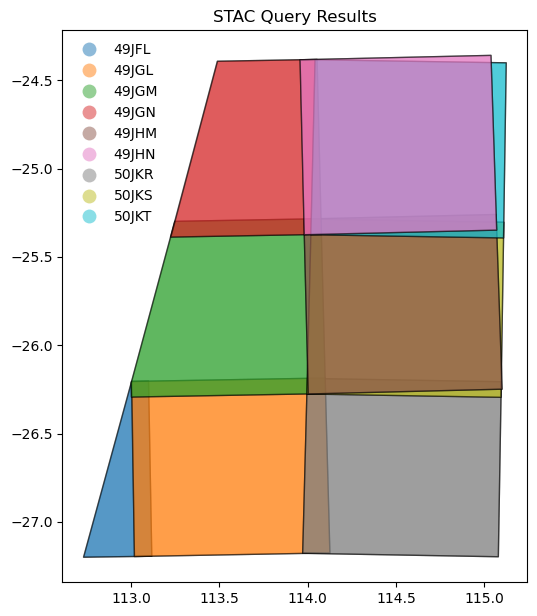

In [4]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

## Plot STAC Items on a Map

In [5]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_2160/1652784297.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


## Construct Dask Dataset

Note that even though there are 9 STAC Items on input, there is only one
timeslice on output. This is because of `groupby="solar_day"`. With that
setting `stac_load` will place all items that occured on the same day (as
adjusted for the timezone) into one image plane.

In [6]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
)
display(xx)

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 1101, x: 1087, time: 1)
Coordinates:
  * y            (y) float64 9kB -2.797e+06 -2.798e+06 ... -3.149e+06 -3.149e+06
  * x            (x) float64 9kB 1.247e+07 1.247e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 8B 2021-09-16T02:34:44.451000
Data variables:
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>

Note that data is not loaded yet. But we can review memory requirement. We can also check data footprint.

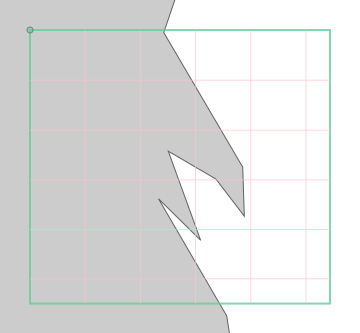

In [7]:
xx.odc.geobox

## Load data into local memory

In [8]:
%%time
xx = xx.compute()

CPU times: user 462 ms, sys: 99.4 ms, total: 562 ms
Wall time: 12.1 s


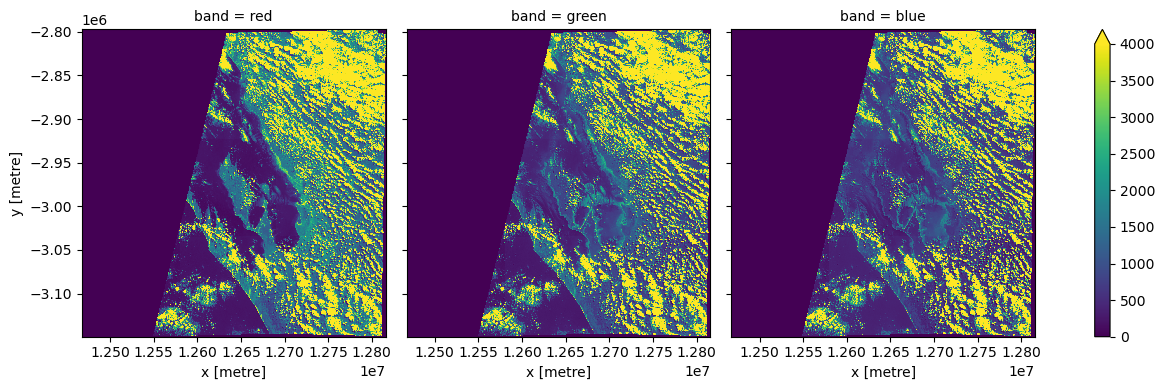

In [9]:
_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

## Load with bounding box

As you can see `stac_load` returned all the data covered by STAC items
returned from the query. This happens by default as `stac_load` has no way of
knowing what your query was. But it is possible to control what region is
loaded. There are several mechanisms available, but probably simplest one is
to use `bbox=` parameter (compatible with `stac_client`).

Let's load a small region at native resolution to demonstrate.

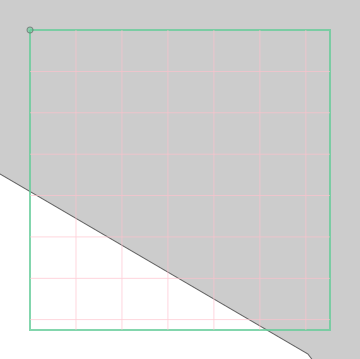

In [10]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [11]:
yy = yy.compute()

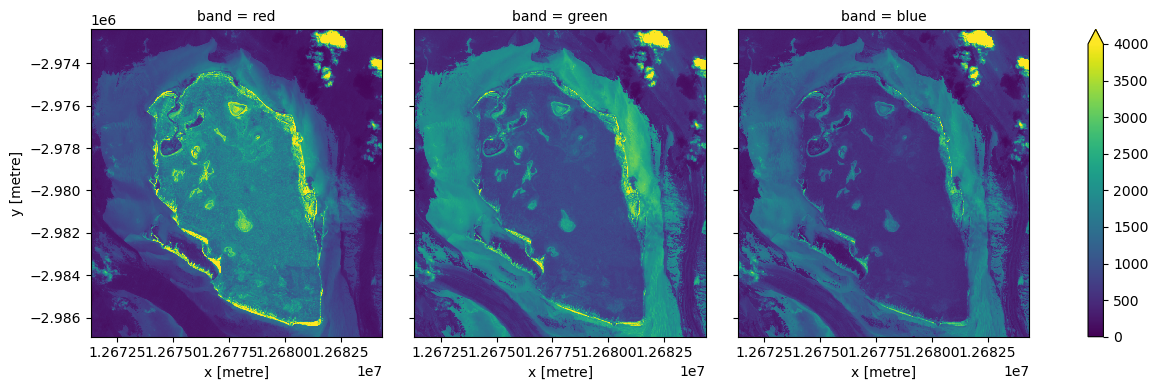

In [12]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

--------------------------------------------------------------